## **GAN is short form of Generative Adversarial Network** and a deep learning architecture. GAN consists of 2 parts, Discriminator and Generator.
The Generator tries to creat fake images and fool the Discriminator, and Discriminator tries to distinguish the images and label them as fake(0) or real(1).


This zero-sum game continuees until the Generator can no longer creat images which fools the Discriminator and the Discriminator cannot be fooled.


There are different types of GAN Models but we are using DCGAN which is the short form of Deep Convolutional GAN.

## Step 1 | Importing libraries

In [1]:
# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display

BinaryCrossentropy = tf.keras.metrics.BinaryCrossentropy()


2024-01-09 13:18:19.887841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 13:18:19.887908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 13:18:19.887958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 13:18:19.910111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 13:18:22.095516: I tensorflow/compiler/

# Step 2 | Preparing data and showing some images

In [2]:
path = os.getcwd()
data_path = os.path.join(path, 'notebooks/data_clean')
root_path = pathlib.Path(data_path)

print(root_path)

/tf/notebooks/data_clean


In [3]:
# prepraing data
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64))

Found 4247 files belonging to 1 classes.


In [4]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

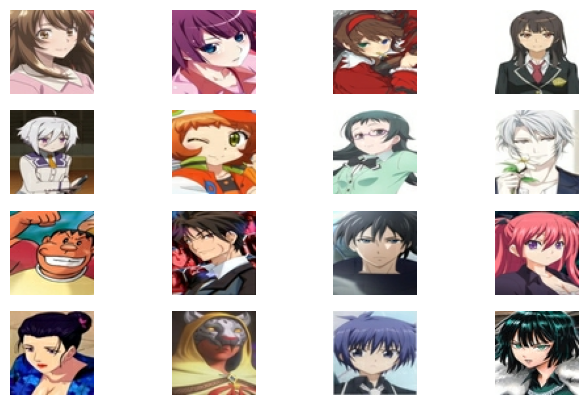

In [5]:
# let's see some images of the dataset
plt.figure(figsize=(8,5))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

# Step 3 | Building Discriminator

**What is Discriminator ?**

The Discriminator is a Neural Network model which tries to distinguish the real images from fake images(generated by Generator) and label them as fake(0) or real(1).

**Notes** :

1.The image size is (64,64), so the input_shape of first conv2d layer should be (64,64,3).

2.The output of Discriminator is either a 0(fake) or 1(real).

3.Using "same" as padding ensures us that the output dimension is not going to change.


4.In the Discriminator function, all activations should be "LeakyReLU", exept the last layer which should be "sigmoid"


5.The last layer is using "sigmoid" as activation function to create a binary output, which real images are labeled as 1 and the fake ones are labeled as 0.


6. The Discriminator downsamples the input shape.

First let's build Discriminator function

In [7]:
# Discriminator
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU", input_shape=(64,64,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model = Discriminator()
D_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0

In [8]:
# optimizer
D_optm = Adam(1e-4)

# Step 4 | Building Generator

**What is Generator ?**

The Generator tries to creat fake images and fool the Discriminator, and Discriminator tries to distinguish the images and label them as fake(0) or real(1).

**Notes :**

1.The latent space is an arbitrarily defined vector space of Gaussian-distributed
values and here I consider 100 as latent_dim.

2.Also units in Dense layer can be (4,4,256) (so it has 4096 nodes)---> 256 versions of 4*4 images.

3.Using "same" as padding ensures us that the output dimension is not going to change.

4.The output shape will be (None, 64, 64, 3) just like the input image(real image) of Discriminator.

5. In Generator, we can use Upsampling or Conv2DTranspose layer to upsample the input.

In [9]:
latent_dim = 100

In [10]:
# Build the Generator function
def Generator():
  generator = Sequential()
  generator.add(Dense(units=4*4*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))

  return generator


# a summary of the Generetor
G_model = Generator()
G_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         295040    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 128)         512       
 chNormalization)                                                
                                                      

In [11]:
# optimizer
G_optm = Adam(1e-4)

# Step 5 | Checking if G and D works

Let's see how each model work befor training

In [12]:
# creating random noise
random_noise = tf.random.normal([1,latent_dim])

In [13]:
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)

2024-01-09 13:18:31.770999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


(-0.5, 63.5, 63.5, -0.5)

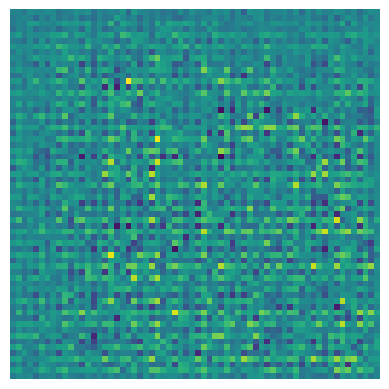

In [14]:
# showing the image output of G_model
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [15]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.49999392]], shape=(1, 1), dtype=float32)


# Step 6 | Training loop

The training function in DCGAN (Deep Convolutional Generative Adversarial Network) is responsible for training the generator and discriminator networks simultaneously. The goal of this training process is to optimize the generator and discriminator models so that the generator can generate realistic images, while the discriminator can accurately distinguish between real and generated images.

**The training process in DCGAN involves two main steps:**

1. Training the Discriminator:
   - The discriminator network is trained first using a batch of real images from the dataset and a batch of generated images from the generator.
   - The discriminator assigns probabilities to each image, indicating whether it believes the image is real or generated.
   - The loss function for the discriminator is calculated based on how well it classifies real and generated images. The goal is to minimize this loss function.
   - The gradients of the loss function with respect to the discriminator's parameters are computed using backpropagation, and then used to update the discriminator's weights.

2. Training the Generator:
   - After updating the discriminator, we train the generator network.
   - The generator takes random noise as input and generates fake images.
   - These generated images are then fed into the updated discriminator.
   - The loss function for the generator is calculated based on how well it fools the discriminator into classifying its generated images as real.
   - Similar to before, gradients of this loss function with respect to generator's parameters are computed using backpropagation, and then used to update its weights.

In [16]:
# The code of this cell is from keras sample.
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [17]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [18]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [19]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [20]:
print(tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is NOT available.")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


In [29]:
# number of epochs
epochs = 250
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/250


133/133 [==============================] - 4s 27ms/step - d_loss: 0.3280 - g_loss: 4.2517
Epoch 2/250
133/133 [==============================] - 4s 26ms/step - d_loss: 0.2552 - g_loss: 2.6550
Epoch 3/250
133/133 [==============================] - 4s 27ms/step - d_loss: 0.2488 - g_loss: 3.0463
Epoch 4/250
133/133 [==============================] - 4s 26ms/step - d_loss: 0.2736 - g_loss: 2.8473
Epoch 5/250
133/133 [==============================] - 3s 25ms/step - d_loss: 0.3076 - g_loss: 3.1652
Epoch 6/250
133/133 [==============================] - 3s 25ms/step - d_loss: 0.3419 - g_loss: 3.5876
Epoch 7/250
133/133 [==============================] - 3s 25ms/step - d_loss: 0.3748 - g_loss: 3.8636
Epoch 8/250
133/133 [==============================] - 3s 25ms/step - d_loss: 0.3111 - g_loss: 2.6868
Epoch 9/250
133/133 [==============================] - 4s 25ms/step - d_loss: 0.2553 - g_loss: 2.9234
Epoch 10/250
133/133 [==============================] - 4s 27ms/step - d_loss: 0.2850 - g_loss

# Step 7 | Using the trained Generated to creat new images

Now we can use the trained Generator to creat new images. Let's show some images generated from the trained Generator.

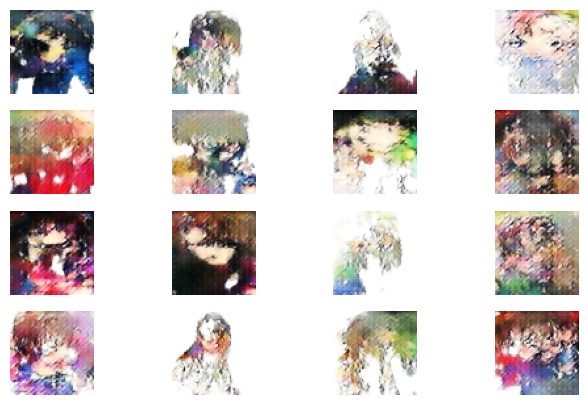

In [49]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model 
generated_images = G_model(noise, training=False)

# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5

plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

In [58]:
# dump model
model.discriminator.save('notebooks/discriminator.h5')
model.generator.save('notebooks/generator.h5')

This images are generated from the trained generator with 35 epochs. In order to have better images you can train the GAN_model with more epochs.